## OpenMP Secuencial vs Paralelo

Para crear la multiplicacion de matrices utilizando openmp vamos a utilizar la solucion que ya  teniamos en la version previa que implementaba la version ingenua : 

dadas dos matrices $A$,$B$ de la forma:
$$A = \begin{pmatrix}
 a_{1 1} & \cdots & a_{1 n} \\
 \vdots & \ddots & \vdots \\
 a_{m 1} & \cdots & a_{m n}
 \end{pmatrix}, B = \begin{pmatrix}
 b_{1 1} & \cdots & b_{1 n} \\
 \vdots & \ddots & \vdots \\
 b_{m 1} & \cdots & b_{m n}
 \end{pmatrix}
 $$

Escritas en los textos como $A:=(a_{i j})_{m \times n}$, $B:=(b_{i j})_{n \times p}$, donde $m,n,p$ indican las filas y columnas de cada matriz, el producto de $A\cdot B$ es:
$C = AB_{}^{}$.

$$ \begin{pmatrix}
 a_{1 1} & \cdots & a_{1 n} \\
 \vdots & \ddots & \vdots \\
 a_{m 1} & \cdots & a_{m n}
 \end{pmatrix} \cdot \begin{pmatrix}
 b_{1 1} & \cdots & b_{1 p} \\
 \vdots & \ddots & \vdots \\
 b_{n 1} & \cdots & b_{n p}
 \end{pmatrix}$$
 
 $$\begin{pmatrix}
 a_{11}b_{11}+ \cdots +a_{1n}b_{n1} & \cdots & a_{11}b_{1p}+ \cdots +a_{1n}b_{np} \\
 \vdots & \ddots & \vdots \\
 a_{m1}b_{11}+ \cdots +a_{mn}b_{n1} & \cdots & a_{m1}b_{1p}+ \cdots +a_{mn}b_{np}
 \end{pmatrix}
$$

Que no es mas que la sumatoria de multiplicar la fila por la columna para cada elemento de la matriz resulta:
$$c_{ij} = \sum_{r=1}^n a_{ir}b_{rj}$$


*Nota[!]:La cantindad de Columnas debe ser igual a la cantidad de filas de la segunda matriz,$A:=(a_{i j})_{m \times n}$, $B:=(b_{i j})_{n \times p}$, tendra como resultado una Matriz $B:=(b_{i j})_{m \times p}$*.

De las observaciones anteriores podemos decir que  para resolver la multiplicación de las matrices $A\cdot B$ es necesario realizar $m*n*p$ multiplicaciones, Seria posible utilizar una gran cantidad de tecnicas como se describe  en[[1][1]]y [[2][2]], para este laboratorio usaremos la que tiene una complejidad de $Θ(n^{3})$ como se muestra en [[3][3]]:
<img src="http://i.imgur.com/Y4OmGFt.png" height="650" width="640">

[1]: https://en.wikipedia.org/wiki/Matrix_multiplication_algorithm#Iterative_algorithm
[2]: https://es.wikibooks.org/wiki/Optimizaci%C3%B3n_del_Producto_de_Matrices
[3]: https://en.wikipedia.org/wiki/Matrix_multiplication_algorithm#Iterative_algorithm


La version ingenua que teniamos al utilzar c era la siguiente : 
```c++
void multiply_matrix(float *mat1, int r1, int c1, float *mat2, int r2, int c2, float *res) {
  int pos_matrix1, pos_matrix2;
  float acc;
  int i, j, k;
  long long t_init = time(NULL);
  for (i = 0; i < r1; i++) {
    for (j = 0; j < c2; j++) {
      acc = 0;
      for (k = 0; k < c1; k++) {
        pos_matrix1 = i * c1 + k;
        pos_matrix2 = c2 * k + j;
        acc += mat1[pos_matrix1] * mat2[pos_matrix2];
      }
      res[i * c2 + j] = acc;
    }
  }
  long long t_end = time(NULL);
  printf("Time: %lld ms\n", (t_end - t_init));
}
```
Al agregar la libreria de openmp y corriendo de forma secuencial la funcion de multiplicacion de matrices nos queda de la siguiente manera : 
```c++
void multiply_matrix(float *mat1, int r1, int c1, float *mat2, int r2, int c2, float *res) {
  int pos_matrix1, pos_matrix2;
  int i, j, k, tid, acc;
  for (i = 0; i < r1 * c2; i++) res[i] = 0;

  time_t t_init = time(NULL);
  double init_t = omp_get_wtime( );

  #pragma omp shared(mat1, r1, c1, mat2, r2, c2, res) private(i, j, k, acc, tid)
  {
    #pragma omp for schedule(dynamic, CHUNK)
    for (i = 0; i < r1; i++) {
      for (j = 0; j < c2; j++) {
        for (k = 0; k < c1; k++) {
          res[i * c2 + j] += mat1[i * c1 + k] * mat2[c2 * k + j];
        }
      }
    }
  }
```

notese que solo hemos agregado las lineas 
```c++
#pragma omp shared(mat1, r1, c1, mat2, r2, c2, res) private(i, j, k, acc, tid)
```
y la linea 
```c++
#pragma omp for schedule(dynamic, CHUNK)
```

Estos pragmas son directivas de preprocesamiento que la libreria entiende de openmp entiende, de forma dinamica al momento de compilar se toma los pragmas y el compilador inyecta el codigo necesario. Esto puede ser visto con las siguientes pruebas de la version secuencial : 

In [3]:
ls

gen.py  Makefile          matrix_mul_OMP.out*   out/
img/    matrix_mul.c      matrix_mul_OMP_seq.c  process.sh
in/     matrix_mul_OMP.c  matrix_mul_seq.out*   readme.ipynb


In [8]:
mkdir compiler

In [11]:
cp matrix_mul_OMP.c compiler/ && cd compiler && pwd

/home/c1b3r/Documents/Developer/HPC/C4rias/Homeworks/Homework2/compiler


In [16]:
ls


matrix_mul_OMP.c


In [17]:
pwd

'/home/c1b3r/Documents/Developer/HPC/C4rias/Homeworks/Homework2/compiler'

In [21]:
# Preprocesamiento : 
!cpp -fopenmp matrix_mul_OMP.c>preprocessing.i

In [23]:
ls


matrix_mul_OMP.c  preprocessing.i


In [24]:
cat preprocessing.i

# 1 "matrix_mul_OMP.c"
# 1 "<built-in>"
# 1 "<command-line>"
# 1 "/usr/include/stdc-predef.h" 1 3 4
# 1 "<command-line>" 2
# 1 "matrix_mul_OMP.c"

# 1 "/usr/lib/gcc/x86_64-linux-gnu/8/include/omp.h" 1 3 4
# 35 "/usr/lib/gcc/x86_64-linux-gnu/8/include/omp.h" 3 4

# 35 "/usr/lib/gcc/x86_64-linux-gnu/8/include/omp.h" 3 4
typedef struct
{
  unsigned char _x[4]
    __attribute__((__aligned__(4)));
} omp_lock_t;

typedef struct
{

  unsigned char _x[8 + sizeof (void *)]
    __attribute__((__aligned__(sizeof (void *))));




} omp_nest_lock_t;


typedef enum omp_sched_t
{
  omp_sched_static = 1,
  omp_sched_dynamic = 2,
  omp_sched_guided = 3,
  omp_sched_auto = 4
} omp_sched_t;

typedef enum omp_proc_bind_t
{
  omp_proc_bind_false = 0,
  omp_proc_bind_true = 1,
  omp_proc_bind_master = 2,
  omp_proc_bind_close = 3,
  omp_proc_bind_spread = 4
} omp_proc_bind_t;

typedef enum omp_lock_hint_t
{
  omp_lock_hint_none = 0,
  omp_lock_hint_uncontended = 1,
  omp_lock_hint_contended = 2,
  omp_lock_

In [26]:
# compilacion  : 
!gcc -S preprocessing.i

In [27]:
ls

matrix_mul_OMP.c  preprocessing.i  preprocessing.s


In [28]:
cat preprocessing.s

	.file	"matrix_mul_OMP.c"
	.text
	.globl	CHUNK
	.section	.rodata
	.align 4
	.type	CHUNK, @object
	.size	CHUNK, 4
CHUNK:
	.long	10
.LC0:
	.string	"%d, %d\n"
.LC1:
	.string	"%f, "
	.text
	.globl	print_matrix
	.type	print_matrix, @function
print_matrix:
.LFB5:
	.cfi_startproc
	pushq	%rbp
	.cfi_def_cfa_offset 16
	.cfi_offset 6, -16
	movq	%rsp, %rbp
	.cfi_def_cfa_register 6
	subq	$32, %rsp
	movq	%rdi, -24(%rbp)
	movl	%esi, -28(%rbp)
	movl	%edx, -32(%rbp)
	movl	-32(%rbp), %edx
	movl	-28(%rbp), %eax
	movl	%eax, %esi
	leaq	.LC0(%rip), %rdi
	movl	$0, %eax
	call	printf@PLT
	movl	$0, -4(%rbp)
	jmp	.L2
.L5:
	movl	$0, -8(%rbp)
	jmp	.L3
.L4:
	movl	-4(%rbp), %eax
	imull	-32(%rbp), %eax
	movl	%eax, %edx
	movl	-8(%rbp), %eax
	addl	%edx, %eax
	cltq
	leaq	0(,%rax,4), %rdx
	movq	-24(%rbp), %rax
	addq	%rdx, %rax
	movss	(%rax), %xmm0
	cvtss2sd	%xmm0, %xmm0
	leaq	.LC1(%rip), %rdi
	movl	$1, %eax
	call	printf@PLT
	addl	$1, -8(%rbp)
.L3:
	movl	-8(%rbp), %eax
	cmpl	-32(%rbp), %eax
	jl	.L4
	movl	$10, %edi
	call	p

Las secciones anteriores permiten observar la inyeccion de el codigo extra de openmp. 


In [31]:
pwd


'/home/c1b3r/Documents/Developer/HPC/C4rias/Homeworks/Homework2/compiler'

In [32]:
cd ..

/home/c1b3r/Documents/Developer/HPC/C4rias/Homeworks/Homework2


In [33]:
ls

compiler/  Makefile             matrix_mul_OMP_seq.c  readme.ipynb
gen.py     matrix_mul.c         matrix_mul_seq.out*
img/       matrix_mul_OMP.c     out/
in/        matrix_mul_OMP.out*  process.sh


Para realizar las graficas, y las matrices aleatorias hemos actuamatizado todo el proceso utilizando un make file 

In [35]:
cat Makefile


PYTHON=python3
C=gcc
LIBS=-fopenmp
time = time
del=rm
NUMBERS := $(shell seq 0 100 2500)

all: matrix generator run

matrix: matrix_mul.c
	$(del) matrix_mul_seq.out
	$(del) matrix_mul_OMP.out	
	$(C) matrix_mul_OMP_seq.c -o matrix_mul_seq.out $(LIBS)
	$(C) matrix_mul_OMP.c -o matrix_mul_OMP.out $(LIBS)


generator: gen.py
	$(foreach i, $(NUMBERS), $(PYTHON) gen.py > matrix_in_$(i).csv  $(i);)

run:
	$(foreach i, $(NUMBERS), $(shell ./matrix_mul_seq.out < matrix_in_$(i).csv > matrix_out_seq_$(i).csv))
	
	$(foreach i, $(NUMBERS), $(shell ./matrix_mul_OMP.out < matrix_in_$(i).csv > matrix_out_omp_$(i).csv))


Este archivo compilara las dos versiones tanto secuenciales como la version paralelizada, que en codigo la multiplicacion de matrices queda de la siguiente forma : 
```c++    
void multiply_matrix(float *mat1, int r1, int c1, float *mat2, int r2, int c2, float *res) {
  int pos_matrix1, pos_matrix2;
  int i, j, k, tid, acc;
  for (i = 0; i < r1 * c2; i++) res[i] = 0;
  
  time_t t_init = time(NULL);
  double init_t = omp_get_wtime( );

  #pragma omp parallel shared(mat1, r1, c1, mat2, r2, c2, res) private(i, j, k, acc, tid)
  {

    #pragma omp for schedule(dynamic, CHUNK)
    for (i = 0; i < r1; i++) {
      for (j = 0; j < c2; j++) {
        for (k = 0; k < c1; k++) {
          res[i * c2 + j] += mat1[i * c1 + k] * mat2[c2 * k + j];
        }
      }
    }
  }
  time_t t_end = time(NULL);
  double end_t = omp_get_wtime( ); 
  printf("{\n");
  printf("\"Normal time\": %ld\n", (t_end - t_init));
  printf("\"OMP time\" : %lf\n", (end_t - init_t));
  printf("}\n");
}
```

notese que el unico pragma que cambia ha sido el pragma mas externo 
```c++
#pragma omp parallel shared(mat1, r1, c1, mat2, r2, c2, res) private(i, j, k, acc, tid)
``` 

> The omp parallel directive explicitly instructs the compiler to parallelize the chosen block of code.



## Datos y Graficas 

Se realiza la ejecucion de ambos codigos el secuencial contra la version paralelizable, se construyeron matrices aleatorias hasta 2500\*2500 :

rangos : *__seq 0 100 2500__*

In [58]:
sizes = [i for i in range(0,2600,100)]
print(sizes)

[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500]


In [42]:
seq = [{
"Normal time": 0,
"OMP time" : 0.000003
}, 
{
"Normal time": 0,
"OMP time" : 0.006689
}, 
{
"Normal time": 0,
"OMP time" : 0.053178
}, 
{
"Normal time": 0,
"OMP time" : 0.192872
},
{
"Normal time": 1,
"OMP time" : 0.487337
}, 
{
"Normal time": 1,
"OMP time" : 1.011959
}, 
{
"Normal time": 2, 
"OMP time" : 1.825386
}, 
{
"Normal time": 3,
"OMP time" : 2.986775
}, 
{
"Normal time": 4, 
"OMP time" : 4.017227
}, 
{
"Normal time": 6,
"OMP time" : 6.644443
}, 
{
"Normal time": 10, 
"OMP time" : 9.536176
}, 
{
"Normal time": 13, 
"OMP time" : 13.584099
}, 
{
"Normal time": 16,
"OMP time" : 16.200789
}, 
{
"Normal time": 22, 
"OMP time" : 22.127861
}, 
{
"Normal time": 27, 
"OMP time" : 26.971850
}, 
{
"Normal time": 34,
"OMP time" : 34.128443
}, 
{
"Normal time": 44, 
"OMP time" : 43.547706
}, 
{
"Normal time": 52, 
"OMP time" : 52.051761
}, 
{
"Normal time": 59, 
"OMP time" : 58.435632
}, 
{
"Normal time": 72, 
"OMP time" : 71.790033
}, 
{
"Normal time": 70, 
"OMP time" : 69.596079
}, 
{
"Normal time": 95, 
"OMP time" : 95.031028
}, 
{
"Normal time": 95, 
"OMP time" : 95.031028
}, 
{
"Normal time": 131, 
"OMP time" : 131.245089
}, 
{
"Normal time": 135, 
"OMP time" : 135.504004
}, 
{
"Normal time": 175,
"OMP time" : 175.279450
}
]

In [70]:
omp = [ 
{
"Normal time": 0,
"OMP time" : 0.003771
},
{
"Normal time": 0, 
"OMP time" : 0.025863
}, 
{
"Normal time": 0,
"OMP time" : 0.094056
}, 
{
"Normal time": 1, 
"OMP time" : 0.234318
}, 
{
"Normal time": 0, 
"OMP time" : 0.497074
}, 
{
"Normal time": 0, 
"OMP time" : 0.823867
}, 
{
"Normal time": 1,
"OMP time" : 1.400690
}, 
{
"Normal time": 2, 
"OMP time" : 2.140094
}, 
{
"Normal time": 4, 
"OMP time" : 3.196072
}, 
{
"Normal time": 5,
"OMP time" : 4.391769
},
{
"Normal time": 5, 
"OMP time" : 4.391769
}, 
{
"Normal time": 6,
"OMP time" : 6.006672
},
{
"Normal time": 8,
"OMP time" : 8.529003
},
{
"Normal time": 9,
"OMP time" : 9.834650
},
{
"Normal time": 12,
"OMP time" : 11.994201
},
{
"Normal time": 15,
"OMP time" : 15.592231
},
{
"Normal time": 20,
"OMP time" : 20.108478
},
{
"Normal time": 23,
"OMP time" : 22.632042
},
{
"Normal time": 28,
"OMP time" : 27.524498
},
{
"Normal time": 35,
"OMP time" : 34.943173
},
{
"Normal time": 39,
"OMP time" : 39.738869
},
{
"Normal time": 48,
"OMP time" : 47.894598
}, 
{
"Normal time": 56,
"OMP time" : 55.829471
},
{
"Normal time": 64,
"OMP time" : 63.519138
},
{
"Normal time": 70,
"OMP time" : 69.918278
},
{
"Normal time": 82,
"OMP time" : 82.696630
}]


In [50]:
import matplotlib.pyplot as plt
%matplotlib inline

In [51]:
omp_nt = [i["Normal time"] for i in omp]

In [52]:
omp_ompt = [i["OMP time"] for i in omp]

In [53]:
omp_ompt

[0.000307,
 0.003771,
 0.025863,
 0.094056,
 0.234318,
 0.497074,
 0.823867,
 1.40069,
 2.140094,
 3.196072,
 4.391769,
 4.391769,
 6.006672,
 8.529003,
 9.83465,
 11.994201,
 15.592231,
 20.108478,
 22.632042,
 27.524498,
 34.943173,
 39.738869,
 47.894598,
 55.829471,
 63.519138,
 69.918278,
 82.69663]

In [54]:
seq_nt = [i["Normal time"] for i in seq]
seq_ompt = [i["OMP time"] for i in seq]

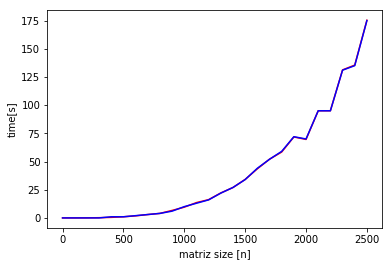

In [67]:
plt.plot(sizes,seq_ompt, 'r')
plt.xlabel('matriz size [n]')
plt.ylabel('time[s]')
plt.plot(sizes,seq_nt, 'b')
plt.xlabel('matriz size [n]')
plt.show()

In [72]:
len(omp_ompt)

27

#### Referencias :
- https://en.wikipedia.org/wiki/Matrix_multiplication_algorithm#Iterative_algorithm
- https://es.wikibooks.org/wiki/Optimizaci%C3%B3n_del_Producto_de_Matrices
- https://en.wikipedia.org/wiki/Matrix_multiplication_algorithm#Iterative_algorithm